# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')
df.head(3)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes


Une vu d'ensemble rapide du dataset:

In [3]:
df.describe()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
count,9565,9563,9582,9582,9488,9582
unique,1382,4,57,4,21,14
top,Ball Aerospace,Data scientist,SQL/R/Python//Big data,Master,"1,5",Paris
freq,748,3865,539,4971,1023,2015


In [4]:
df.dtypes

Entreprise      object
Metier          object
Technologies    object
Diplome         object
Experience      object
Ville           object
dtype: object

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [5]:
df.shape[0]

9582

Il y a `9582` lignes dans le dataset

In [6]:
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Il y a:
- `17` lignes ou il manque une **entreprise**
- `19` lignes ou il manque un **metier**
- `94` lignes ou il manque une **experience**

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

Voyons comment sont répartis les valeurs manquante (pour la colone experience) entre les metiers

In [7]:
def get_exp_nan_by_metier_details():
    # Getting number of nan in `Experience` for each `Metier`
    df_isna = df.isna()
    df_isna["Metier"] = df["Metier"]
    final_df = df_isna[["Metier", "Experience"]].groupby(
        "Metier", dropna=False).sum().rename(columns={'Experience': 'NaN number'})

    # Getting number of NOT nan in `Experience` for each `Metier`
    final_df["Not NaN number"] = df.groupby("Metier", dropna=False)[
        "Experience"].count()

    # Computing percent of nan in `Experience` for each `Metier`
    final_df["NaN percent"] = final_df.apply(
        lambda r: r["NaN number"] / (r["NaN number"] + r["Not NaN number"]) * 100, axis=1)

    return final_df

In [8]:
get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,23,2100,1.083373
Data engineer,20,2327,0.852152
Data scientist,32,3833,0.827943
Lead data scientist,19,1209,1.547231
NaN,0,19,0.000000


-> Tous les metiers ont des valeurs manquantes pour l'experience (environ 1% des profiles).

-> Les profiles sans metier (à prédire) n'ont pas de valeur manquante pour l'experience

In [9]:
df["Experience"].dtypes

dtype('O')

La colone "Experience" est de type `object`, il faut la convertir en `float` pour pouvoir faire des calcules

In [10]:
df["Experience"] = df["Experience"].replace(",", ".", regex=True).astype(float)
df["Experience"].dtypes

dtype('float64')

On peut maintenant calculer:
- la medianne de l'experience des Data Scientist
- la moyenne de l'experience des Data Engineer

In [11]:
df_by_metier = df.groupby("Metier")

ds_median = df_by_metier.get_group("Data scientist")["Experience"].median()
de_mean = df_by_metier.get_group("Data engineer")["Experience"].mean()

print(f"Data scientist median experience: {ds_median}")
print(f"Data Engineer mean experience: {de_mean:.2f}")

Data scientist median experience: 2.0
Data Engineer mean experience: 2.98


Et remplacer les NaN

In [12]:
# Replacing NaN in `Experience` by the mean for Data Scientist
df.loc[(df["Metier"] == "Data scientist") & (
    df["Experience"].isna()), "Experience"] = ds_median
df.loc[(df["Metier"] == "Data engineer") & (
    df["Experience"].isna()), "Experience"] = de_mean

get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,23,2100,1.083373
Data engineer,0,2347,0.000000
Data scientist,0,3865,0.000000
Lead data scientist,19,1209,1.547231
NaN,0,19,0.000000


On remplace aussi les valeurs manquante dans `Experience` pour les autres valeurs de `Metier` (par la medianne)

In [13]:
for metier in ["Data architecte", "Lead data scientist"]:
    metier_mean = df_by_metier.get_group(metier)["Experience"].median()
    df.loc[(df["Metier"] == metier) & (
        df["Experience"].isna()), "Experience"] = metier_mean

In [14]:
get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,0,2123,0.0
Data engineer,0,2347,0.0
Data scientist,0,3865,0.0
Lead data scientist,0,1228,0.0
NaN,0,19,0.0


=> Il n'y a plus de valeurs manquantes dans la colone `Experience`

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [15]:
df.groupby("Metier").mean()

,Experience
Metier,
Data architecte,2.995054
Data engineer,2.984959
Data scientist,2.241268
Lead data scientist,3.958062


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

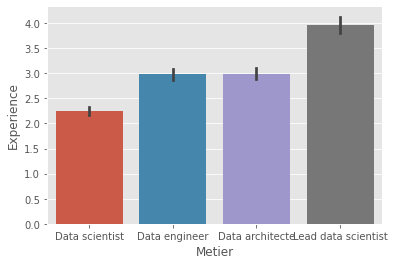

In [16]:
sns.barplot(x="Metier", y="Experience", data=df, order=[
            "Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])
plt.show()

Voila une représentation simple de la moyenne de l'experience pour chaque métier

Mais représenter simplement la moyenne "cache" des informations, comme la distribution. On peut utiliser, par exemple, des "boîte à moustaches" (**Box plot**) en complément pour représenter plus d'informations (médiane, quartiles, outliers...)

(La moyenne est ici représenté par un petit point blanc)

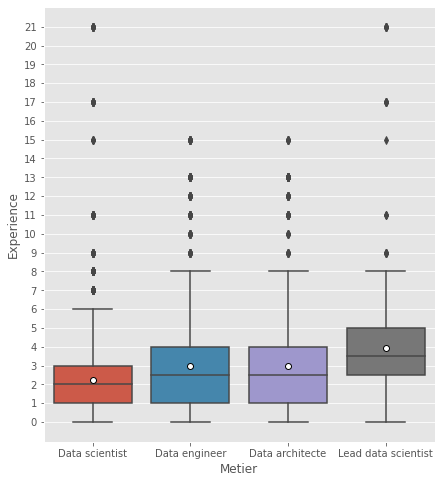

In [17]:
fig, ax = plt.subplots(figsize=(7, 8))
sns.boxplot(x="Metier", y="Experience", data=df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)

ax.set_yticks(np.arange(0, df["Experience"].max() + 1, 1))
plt.show()

On peut même combiner le "box plot" avec un "strip plot" pour voir les données directement

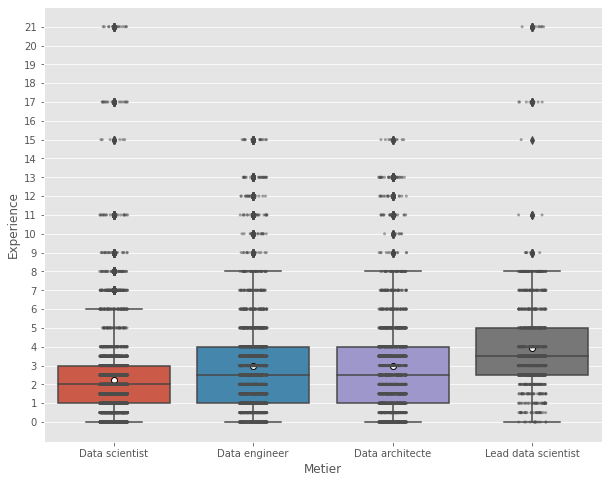

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x="Metier", y="Experience", data=df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)
sns.stripplot(x="Metier", y="Experience", data=df, color=".3", alpha=0.5, size=3,
              order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)

ax.set_yticks(np.arange(0, df["Experience"].max() + 1, 1))
plt.show()

On peut donc remarquer que :
- Même en ayant la moyenne d'expériences la plus basse, certains data scientist ont beaucoup d'expériences (plus que les data engineers ou data architectes).
- L'experience est renseigné par "palier", des chiffres rond ou `,5` au début.
- Les Data Engineer et les Data architecte semble avoir une répartiton de l'expérience similiaire.
- Il y a un peu la même chose pour les Data Scientist et les Lead Data Scientist, même si les Lead Data Scientist ont plus d'expéreinces.



### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Pour séparer les données en 4 catégories, il faut que je définisse des valeurs limites entre chaque groupe.

On peut déjà observer la répartitions générale de l'experience sur ce boxplot:

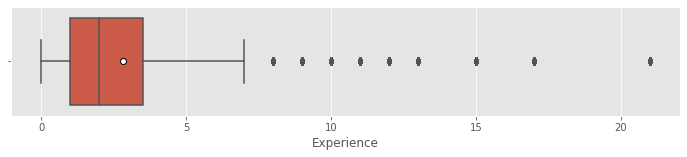

In [19]:
fig, ax = plt.subplots(figsize=(12, 2))
sns.boxplot(x=df["Experience"], showmeans=True, meanprops={
            "marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}, ax=ax)
# sns.stripplot(x=df["Experience"], data=df, color=".3", alpha=0.1, size=3, ax=ax)
plt.show()

Pour analyser ma categorisation, je fais une fonction pour afficher la répartition des Metiers dans chaque tranche d'experience

In [20]:
def plot_metier_in_exp_plot(df):
    exp_cat_lst = ["débutant", "confirmé", "avancé", "expert"]
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    for i, exp in enumerate(exp_cat_lst):
        metier_rep = df[df["Exp_label"] == exp]["Metier"].value_counts(
            normalize=True).mul(100)
        sns.barplot(x=metier_rep.index, y=metier_rep.values, ax=ax[i], order=[
                    "Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])
        ax[i].set_ylim(0, 100)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
        ax[i].title.set_text(exp)

    plt.show()

J'ai d'abord pensé à utiliser les quartiles : concrètement, un "avancé" aurais plus d'experience que 50% des autres profiles et un "expert" plus que 75% des autres...

`pd.qcut()` permet justement de diviser les lignes en groupe en fonction des quartiles

Bins limit: [ 0.   1.   2.   3.5 21. ]
Profiles repartition in Exp_label :
 débutant    29.336255
avancé      26.779378
expert      22.688374
confirmé    21.195992
Name: Exp_label, dtype: float64


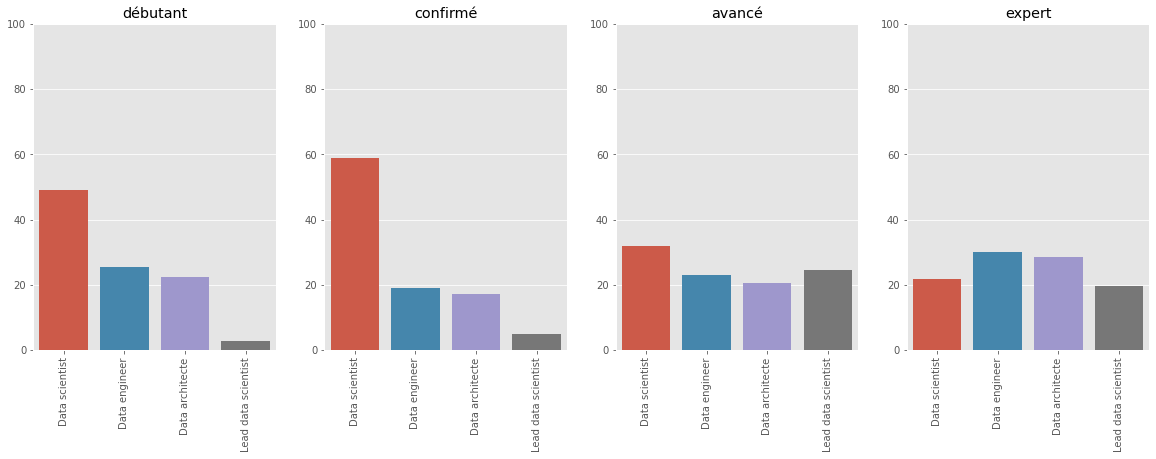

In [21]:
df["Exp_label"], bins = pd.qcut(df["Experience"], 4, labels=[
                                "débutant", "confirmé", "avancé", "expert"], retbins=True)
print(f"Bins limit: {bins}")
print("Profiles repartition in Exp_label :\n",
      df["Exp_label"].value_counts(normalize=True).mul(100))

plot_metier_in_exp_plot(df)

Mais finalement, je ne suis pas sur que les limites soit pertinente. On est considéré comme expert après seulement 3,5 ans d'experiences ! Et puis il me semblerais logique qu'il y ai moins d'expert que de débutant.

Il vaudrait peut être mieu choisir des limites "à la main" qui me semblerait logique avec l'experience que j'ai du metier. Disont que:

- Un débutant -> à 1 ans d'experience ou moins

- Un confirmé -> à entre 1 et 3 ans d'experiences (3 ans d'experiences, c'est le 3ème quartile des Data Scientist et c'est presque le premier quartile des Lead Data Scientist. Peut être une année a partir de laquelle les Data Scientist passe à Lead Data Scientist. Ça pourrais être intéressant de mettre une limitte à ce niveau la)
  
- Un avancé -> à entre 3 et 15 ans d'experiences

- Un expert -> à plus de 15 ans d'experiences

Bins limit: [ 0  1  3 15 50]
Profiles repartition in Exp_label :
 confirmé    38.332290
avancé      31.788771
débutant    29.336255
expert       0.542684
Name: Exp_label, dtype: float64


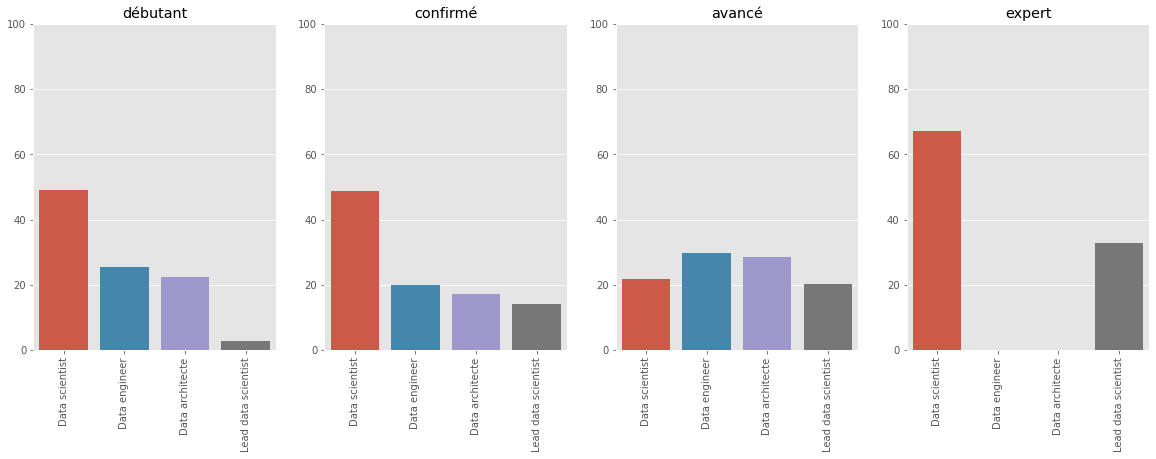

In [22]:
df["Exp_label"], bins = pd.cut(df["Experience"], [0, 1, 3, 15, 50], labels=[
                               "débutant", "confirmé", "avancé", "expert"], retbins=True, include_lowest=True)
print(f"Bins limit: {bins}")
print("Profiles repartition in Exp_label :\n",
      df["Exp_label"].value_counts(normalize=True).mul(100))

plot_metier_in_exp_plot(df)

Étonament il y a toujours plus de "Data Scientist" que de "Lead Data Scientist" dans la catégorie "Expert" alors qu'intuitivement je me serais attendu à voir les Data Scientist expérimentés passer Lead Data Scientist.

On peut visualiser les limites des catégories sur le boxplot de la dernière question:

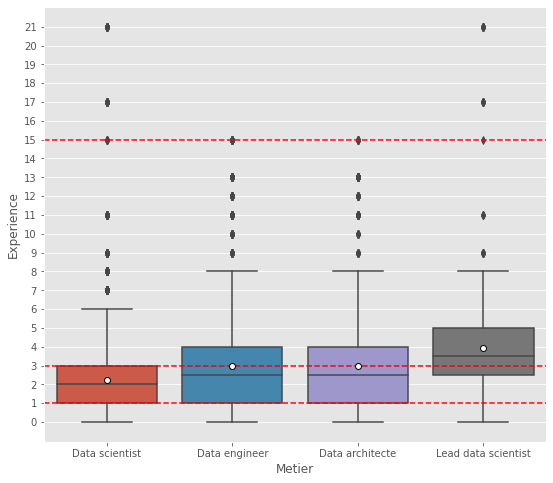

In [23]:
fig, ax = plt.subplots(figsize=(9, 8))
sns.boxplot(x="Metier", y="Experience", data=df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)

for bin_lim in bins[1:-1]:
    plt.plot([-.5, 3.5], [bin_lim, bin_lim], "--", color="red")

ax.set_yticks(np.arange(0, df["Experience"].max() + 1, 1))
plt.show()

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Les technologies sont sous forme de string et non de liste, il va falloir les convertir.

In [24]:
print(df["Technologies"].dtype)
print(type(df["Technologies"][0]))

object
<class 'str'>


On nettoi aussi un peu les données:
- En supprimant les doubles slash `//`, qui créent une techno "vide" (`""`)
- En mettant en miniscule tout les caractères (pour que, par exemple, `"machine learning"` et `"Machine learning"` soient considéré comme la même technologie)
- En évitant qu'un profile ai renseigné 2 fois la même technologie et fausse les comptes (avec un `set()`)
- En traitant quelques cas particuliers:
  - Je ne crois pas que la technologie `"NoSQ"` existe, il sagit surement d'une faute de frappe pour `"NoSQL"`. Je vais corriger ça avec une regex
  - Dans nos listes, il existe les technologie `"Hadoop(HDFS)"`, `"Hadoop"` et `"HDFS"` qui sont similaire. Je pense convertir `"Hadoop(HDFS)"` en `"Hadoop"` et `"HDFS"`.

In [25]:
df["Technologies"] = df["Technologies"].apply(lambda str_lst: sorted(list(set(
    re.sub(r"nosq(?!l)", "nosql", str_lst
           .lower()
           .replace("//", "/")
           .replace("hadoop(hdfs)", "hadoop/hdfs")
           ).split("/")
))))

print(type(df["Technologies"][0]))

<class 'list'>


On peut maintenant compter les technologies, en comptant bien les éléments dans chaque liste (et pas les listes directement)

In [26]:
def to_1D(series):
    """Flatten a Series of list"""
    return pd.Series([x for _list in series for x in _list])


techo_count = to_1D(df["Technologies"]).value_counts()
techo_count.head(5)

python    6627
r         4374
sql       2581
java      1719
hadoop    1687
dtype: int64

Les 5 technologies les plus utilisées sont : le Python, le R, le SQL, le Java et Hadoop

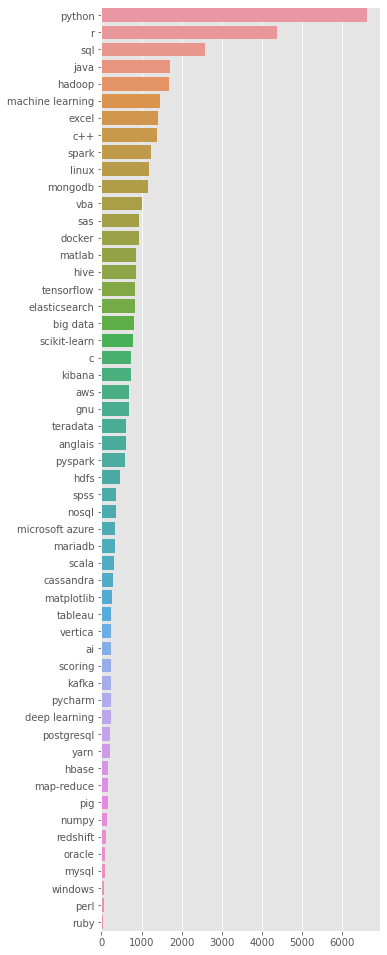

In [27]:
fig, ax = plt.subplots(figsize=(5, 17))
sns.barplot(x=techo_count.values, y=techo_count.index, ax=ax)
plt.show()

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### Preprocessing

Il faut d'abord préprocesser les données :

`Metier` : 
  - Gérer les valeurs manquante : étant donnée que ses profiles sont la pour la question 9, je les supprimes
  - Encoder : avec du "one hot encoding"


`Technologies` :
  - Convertir les string en list et appliquer le preprocessing détaillé à la question 7
  - Encoder : avec du "one hot encoding"


`Experience` :
  - Convertir les strings en float
  - Gérer les valeurs manquante : comme dans la question 3, en utilisant la mediane
  - Créer `Exp_label`
  - Encoder : avec du "ordinal encoding"

=> Finalement, j'ai décidé de ne pas utiliser `Experience`. Quand cette feature était présente, l'algorithme de clustering séparait surtout les profiles expérimenté et non expérimenté et je ne trouve pas ça très intéressant.


`Diplome` :
  - Encoder : avec du "ordinal encoding"

=> En l'ajoutant les metrics étaient moins bonne, je décidé de ne pas utiliser cette feature


`Entreprise` :
  - Passer tout en minuscule (certaines entreprises ne sont pas écrites de la même manière au niveau de la case)
  - Encoder : avec du "one hot encoding"

=> Il y a trop d'entreprise, je décidé de ne pas utiliser cette feature pour l'instant

`Ville`:
  - Encoder : avec du "one hot encoding"

=> En l'ajoutant les metrics étaient moins bonne, je décidé de ne pas utiliser cette feature

Pour faire tout ça, j'ai créer les fonctions suivantes :

In [28]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


def convert_column_to_float(df, column):
    df["Experience"] = df["Experience"].replace(
        ",", ".", regex=True).astype(float)


def replace_nan_by_categorical_median(df, column, cat_col, param):
    P_KEY = f"{column}_median"
    if P_KEY not in param:
        param[P_KEY] = df.groupby(cat_col)[column].median().to_dict()

    for cat in df[cat_col].unique():
        df.loc[(df[cat_col] == cat) & (df[column].isna()), column] = param[P_KEY].get(
            cat, df.loc[df[cat_col] == cat, column].median())


def drop_nan(df, column):
    df.dropna(subset=[column], inplace=True)


def lower_column(df, column):
    df[column] = df[column].str.lower()


def drop_column(df, column):
    df.drop(column, axis=1, inplace=True)


def ordinal_encoding(df, column, ordered_cat_lst, param):
    P_KEY = f"{column}_ordinal_encoder"
    if P_KEY not in param:
        param[P_KEY] = OrdinalEncoder(categories=[ordered_cat_lst])
        param[P_KEY].fit(df[[column]])

    df[f"{column}_encoded"] = param[P_KEY].transform(df[[column]])


def one_hot_encoding(df, column, param):
    P_KEY = f"{column}_one_hot_encoder"
    if P_KEY not in param:
        param[P_KEY] = OneHotEncoder()
        param[P_KEY].fit(df[[column]])

    ohe_result = param[P_KEY].transform(df[[column]])
    ohe_df = pd.DataFrame(
        ohe_result.toarray().astype(int),
        columns=[f"{column}_{cat}" for cat in param[P_KEY].categories_[0]],
        index=df.index
    )
    return df.join(ohe_df)


def list_to_one_hot_encoding(df, column, param):
    P_KEY = f"{column}_lst_to_one_hot_encode"
    if P_KEY not in param:
        param[P_KEY] = sorted(to_1D(df[column]).unique().tolist())
        one_hot = df[column].str.join(
            '|').str.get_dummies().add_prefix(f"{column}_")
        return df.join(one_hot)
    else:
        for tech in param[P_KEY]:
            df[f"{column}_{tech}"] = df[column].apply(
                lambda lst: 1 if tech in lst else 0)
        return df


def add_quantile_segmented_column(df, column, new_column, bins, bin_labels, param):
    KEY = f"{column}_q_bins"

    if KEY not in param:
        df[new_column], param[KEY] = pd.qcut(
            df[column], bins, labels=bin_labels, retbins=True)
    else:
        df[new_column] = pd.cut(df[column], param[KEY],
                                include_lowest=True, labels=bin_labels)


def add_segmented_column(df, column, new_column, bins, bin_labels, param):
    KEY = f"{column}_bins"

    if KEY not in param:
        df[new_column], param[KEY] = pd.cut(
            df[column], bins, labels=bin_labels, retbins=True, include_lowest=True, right=False)
    else:
        df[new_column] = pd.cut(df[column], param[KEY],
                                include_lowest=True, labels=bin_labels)


def add_exp_label(df, param):
    add_segmented_column(df, "Experience", "Exp_label", [0, 1, 3, 15, 100], [
                         "débutant", "confirmé", "avancé", "expert"], param)


def preprocess_technologies(df):
    df["Technologies"] = df["Technologies"].apply(lambda str_lst: list(set(
        re.sub(r"nosq(?!l)", "nosql", str_lst
               .lower()
               .replace("//", "/")
               .replace("hadoop(hdfs)", "hadoop/hdfs")
               ).split("/")
    )))

Que j'appelle ensuite dans une fonction de preprocessing :

In [29]:
def preprocess_for_clutering(df, param=None):
    if param is None:
        param = {}

    df = df.copy()
    drop_nan(df, "Metier")  # (to predict in question 9)

    # Metier
    df = one_hot_encoding(df, "Metier", param)
    drop_column(df, "Metier")

    # Technologies
    preprocess_technologies(df)
    df = list_to_one_hot_encoding(df, "Technologies", param)
    drop_column(df, "Technologies")

    # Exeprience
    # convert_column_to_float(df, "Experience")
    # replace_nan_by_categorical_median(df, "Experience", "Metier", param)
    # add_exp_label(df, param)
    # drop_column(df, "Exp_label")
    drop_column(df, "Experience")

    # Diplome
    # ordinal_encoding(df, "Diplome", ['No diploma', 'Bachelor', 'Master', 'Phd'], param)
    drop_column(df, "Diplome")

    # Entreprise
    # lower_column(df, "Entreprise")
    # df = one_hot_encoding(df, "Entreprise")
    drop_column(df, "Entreprise")

    # Ville
    # df = one_hot_encoding(df, "Ville", param)
    drop_column(df, "Ville")

    return df, param


def preprocess_for_analyze(df, param=None):
    if param is None:
        param = {}

    df = df.copy()

    # Technologies
    preprocess_technologies(df)

    # Exeprience
    convert_column_to_float(df, "Experience")
    replace_nan_by_categorical_median(df, "Experience", "Metier", param)
    add_exp_label(df, param)

    # Entreprise
    lower_column(df, "Entreprise")

    return df, param

#### Clustering

J'ai décidé d'utiliser "K-Means clustering".

Il me semblerais intéressant que l'algorithme arrive a différencier les deux types de profiles présent dans les données:
- Les profiles plutôt "data science" : (surtout les Data Scientist et Lead Data Scientist) qui font du machine learning (entrainer des modèles, faire des prédicitions...)
- Les profiles plutôt "data ingineering" : (surtout les Data Engineer et Data Architect) qui sont plus chargé de gérer les donées (créer des pipelines, des data wharehouse ou data lake...)

Je pense qu'avec les technologies utilisé cette distinction est possible

In [30]:
from sklearn.cluster import KMeans
SEED = 42

# Preprocessing
new_df = pd.read_csv("data.csv")
train_df, preprocess_param = preprocess_for_clutering(new_df)

# Training
kmeans = KMeans(n_clusters=2, random_state=SEED).fit(train_df)

# Prediciton
train_df["cluster"] = kmeans.predict(train_df)


# Creating new DataFrame to analyze result
df_cluster, _ = preprocess_for_analyze(new_df.join(train_df["cluster"]))
drop_nan(df_cluster, "cluster")

df_cluster.head(3)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,cluster,Exp_label
0,sanofi,Data scientist,"[python, matlab, tensorflow, pyspark, scikit-l...",Master,1.0,Paris,0.0,confirmé
1,massachusetts general hospital(mgh),Data architecte,"[python, scala, java, mongodb]",Master,3.0,Marseille,1.0,avancé
2,delve,Lead data scientist,"[python, teradata, r, tensorflow, spss, scikit...",Master,3.0,Nantes,0.0,avancé


#### Metrics

##### Silhouette Score

Après des recherches, j'ai vu que le "Silhouette Score" était une metrics très utilisé pour évaluer la qualité des clusters

In [31]:
silhouette_mean = sk.metrics.silhouette_score(
    train_df[train_df.columns[:-1]], train_df["cluster"])
print(f"Silhouette score: {silhouette_mean:.3f}")

Silhouette score: 0.187


Le score est exprimé entre -1 et 1.

Ici il est au dessus de 0, les cluster sont donc bien séparés, mais de peu (seulement 0,18). Je pense que c'est normal, même si ce sont des domaines différent, la data science et le data engineering sont quand même proches.

On peut aussi représenter le silhouette score de chaque profile dans un graphique :

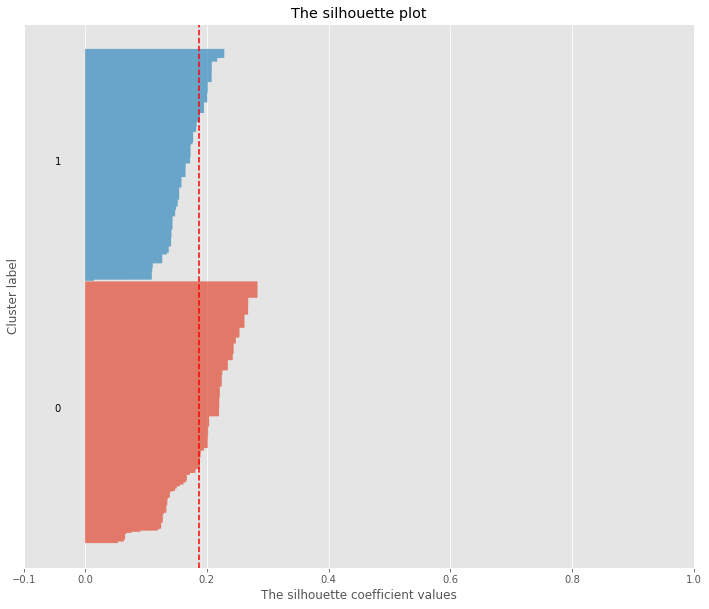

In [32]:
# Silhoutte plot
fig, ax = plt.subplots(figsize=(12, 10))

slihoutte_val = sk.metrics.silhouette_samples(
    train_df[train_df.columns[:-1]], train_df["cluster"])

y_lower = 10
for i in train_df["cluster"].unique():
    cluster_val = slihoutte_val[train_df["cluster"] == i]
    cluster_val.sort()

    y_upper = y_lower + cluster_val.shape[0]
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_val,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * cluster_val.shape[0], str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_mean, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

##### Rand Index

En faisant mes recherches sur les metrics utilisées dans le clustering, j'ai lu que quand on connaissait à l'avance les cluster qu'on voulait, on pouvait utiliser le "Rand Index" évaluer la similarité entre les cluster recherchés et les clusters obtenus.

Il existe une version "ajusté" du Rand Index qui prend en compte la hasard.

In [33]:
true_label = df_cluster["Metier"].replace(
    ['Data scientist', 'Data architecte', 'Lead data scientist', 'Data engineer'],
    [0, 1, 0, 1]
)

rand_score = sk.metrics.rand_score(true_label, df_cluster["cluster"])
adjusted_rand_score = sk.metrics.adjusted_rand_score(
    true_label, df_cluster["cluster"])

print(f"Rand Index: {rand_score:.2f}")
print(f"Adjusted Rand Index: {adjusted_rand_score:.2f}")

Rand Index: 1.00
Adjusted Rand Index: 0.99


Le score du Rand Index est entre 0 et 1.

Et il est ici de 1 ! Le K-Means clustering a réussi à séparer les Data Scientist/Lead Data Scientist des Data Engineer/Data Architect

------
Par curiosité, j'ai testé l'algorithme en utilisant uniquement la feature `Technologies` et j'ai obtenu les metrics:
- Silhouette score -> `0.156`
- Rand Index -> `0.86`
- Adjusted Rand Index -> `0.72`
 
Ce qui me semble être des plutôt bon score pour le peu d'information !

#### Analyse des clusters

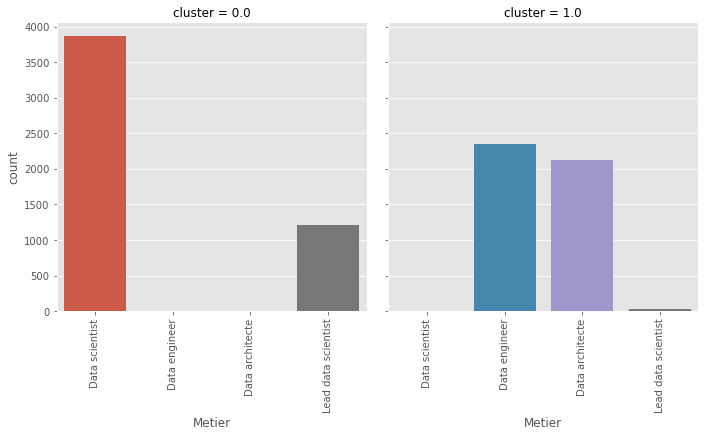

In [34]:
f_grid = sns.catplot(x="Metier", col="cluster", data=df_cluster, kind="count", height=5, aspect=1,
                     order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])

for grid_line in f_grid.axes:
    for sub_ax in grid_line:
        sub_ax.set_xticklabels(sub_ax.get_xticklabels(), rotation=90)
plt.show()

L'algorithme à effecivement séparé les les "Data Scientist/Lead Data Scientist" et les "Data Engineer/Data Architect"

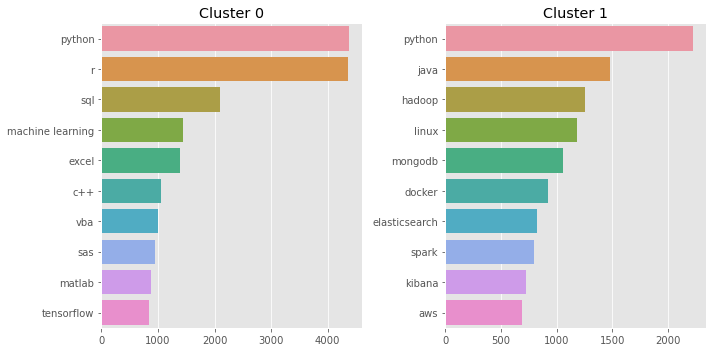

In [35]:
c0_tech_count = to_1D(
    df_cluster[df_cluster["cluster"] == 0]["Technologies"]).value_counts()[:10]
c1_tech_count = to_1D(
    df_cluster[df_cluster["cluster"] == 1]["Technologies"]).value_counts()[:10]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=c0_tech_count.values, y=c0_tech_count.index, ax=ax[0])
sns.barplot(x=c1_tech_count.values, y=c1_tech_count.index, ax=ax[1])

ax[0].title.set_text("Cluster 0")
ax[1].title.set_text("Cluster 1")
fig.tight_layout()
plt.show()

On peut reconnaitre les technologies caractéristiques de chaque domaine:

Data Science (cluster 0): le python, le R, le machine learning, tensorflow...

Data Engineering (cluster 1): le python, le java (utilisé pour Hadoop), Hadoop, spark...

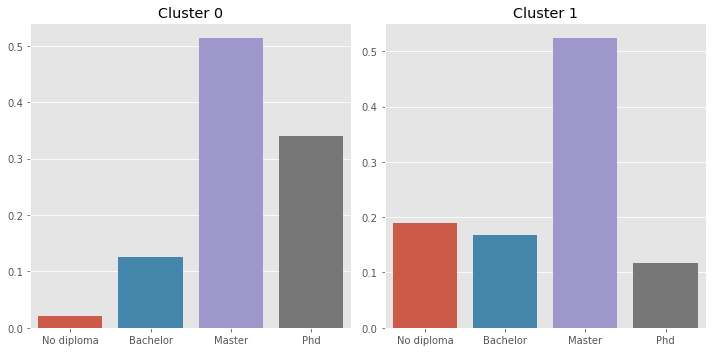

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for cluster in [0, 1]:
    diplome_count = df_cluster[df_cluster["cluster"] ==
                               cluster]["Diplome"].value_counts(normalize=True)
    sns.barplot(y=diplome_count.values, x=diplome_count.index,
                ax=ax[cluster], order=["No diploma", "Bachelor", "Master", "Phd"])
    ax[cluster].title.set_text(f"Cluster {cluster}")

fig.tight_layout()
plt.show()

Il ya plus de Phd dans le cluster data science (0) et il y a plus de sans diplome dans le cluster data engineering (1)

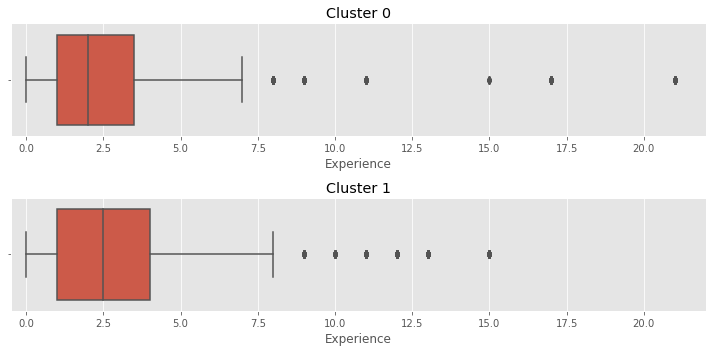

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
for cluster in [0, 1]:
    cluster_exp = df_cluster[df_cluster["cluster"] == cluster]
    sns.boxplot(x=cluster_exp["Experience"], ax=ax[cluster])
    ax[cluster].title.set_text(f"Cluster {cluster}")
    # set x limit
    ax[cluster].set_xlim(-.5, 22)

fig.tight_layout()
plt.show()

Les profiles les plus expérimenté sont dans le cluster data science, ces metiers doivent exister depuis plus longtemps.

Mais la plus part des profiles du cluster data science sont assez peu expériementé (en général moins que le cluster data engineering), c'est peut être du à la récente popularité du metier Data Scientist ("sexiest job of the century" et autre).

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### Exploration des feature restantes

##### Ville

Regardons la répartition des Metier dans chaque ville

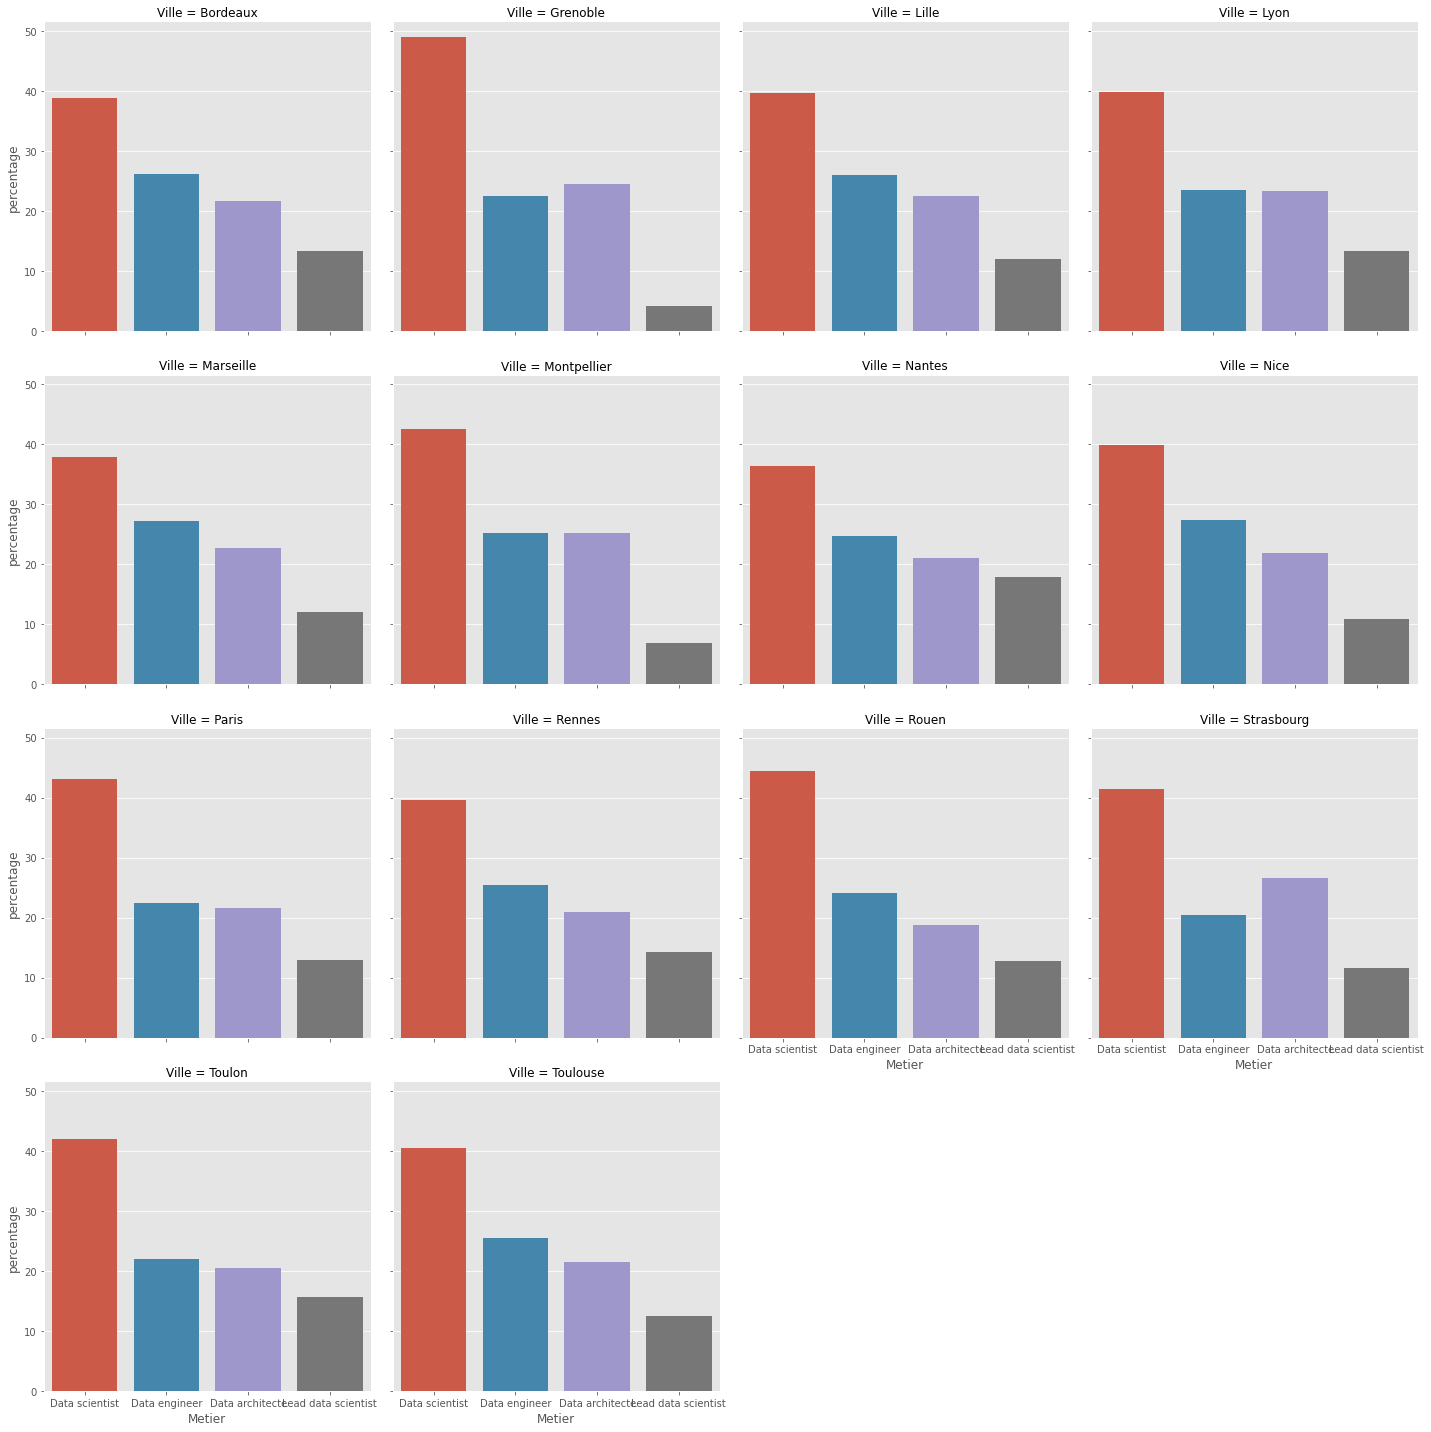

In [38]:
test = df.groupby("Ville")["Metier"].value_counts(
    normalize=True).mul(100).rename('percentage').reset_index()
sns.catplot(x="Metier", y="percentage", kind="bar", data=test, col="Ville", col_wrap=4, order=[
            "Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])

=> Toutes les villes semblent avoir une répartition des metiers assez similaire

##### Entreprise

Regardons la répartitions des Metier dans les 20 Entreprises avec le plus de profiles au seins de nos données :

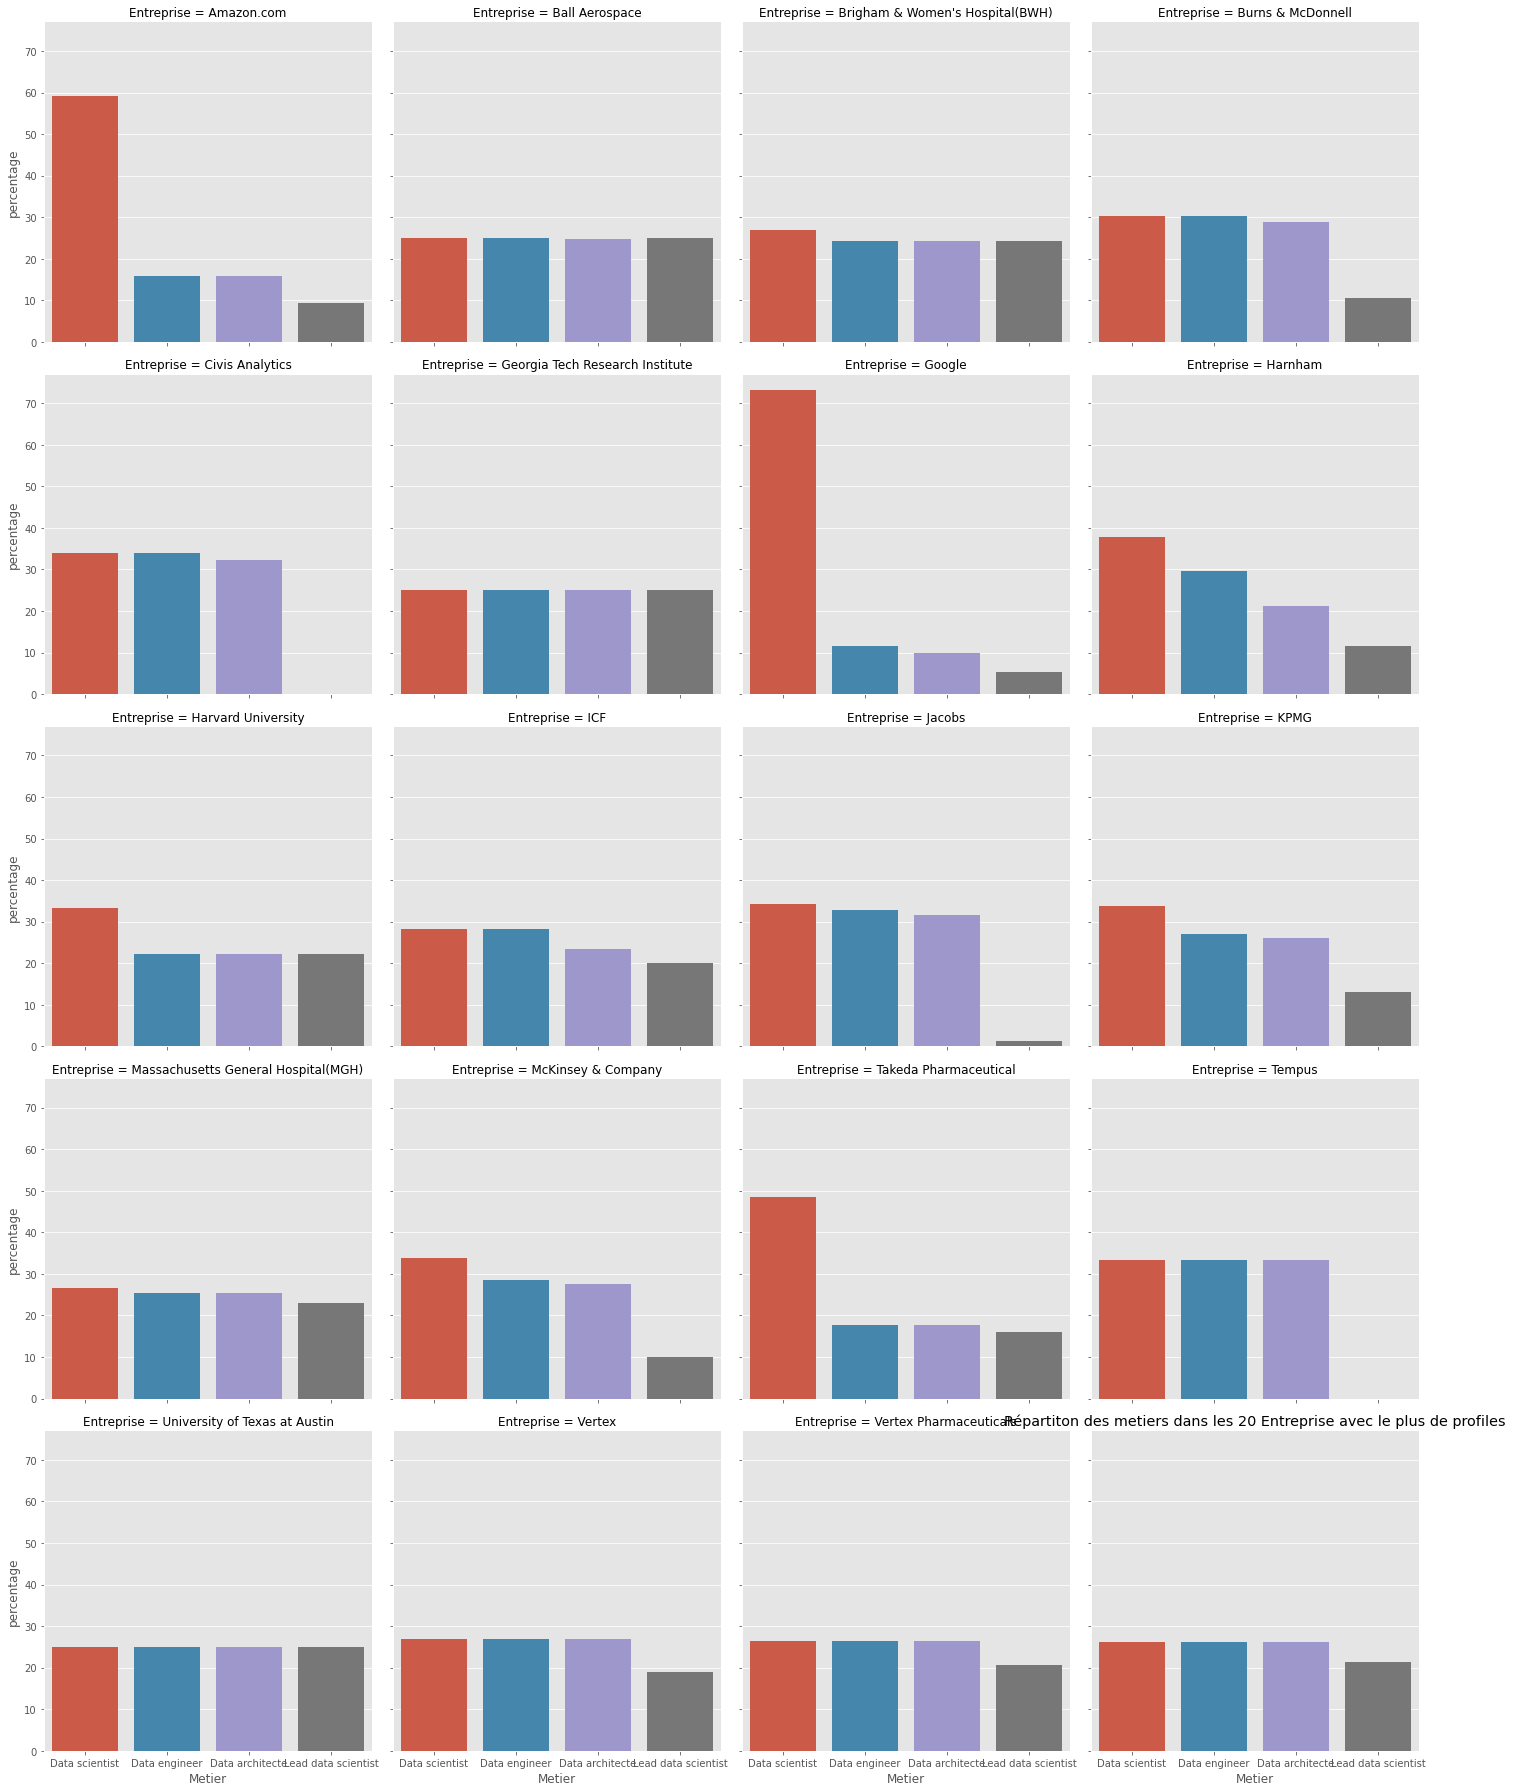

In [39]:
test = df.groupby("Entreprise")["Metier"].value_counts(
    normalize=True).mul(100).rename('percentage').reset_index()
top = df["Entreprise"].value_counts()[:20].index.tolist()

sns.catplot(x="Metier", y="percentage", kind="bar", data=test[test["Entreprise"].isin(
    top)], col="Entreprise", col_wrap=4, order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])
plt.title("Répartiton des metiers dans les 20 Entreprise avec le plus de profiles")
plt.tight_layout()
plt.show()

=> Certaine entreprise pourraient être intéressente mais il y en a beaucoup, je ne vais pas pouvoir toutes les garder

Text(0, 0.5, "Nombre d'entreprise")

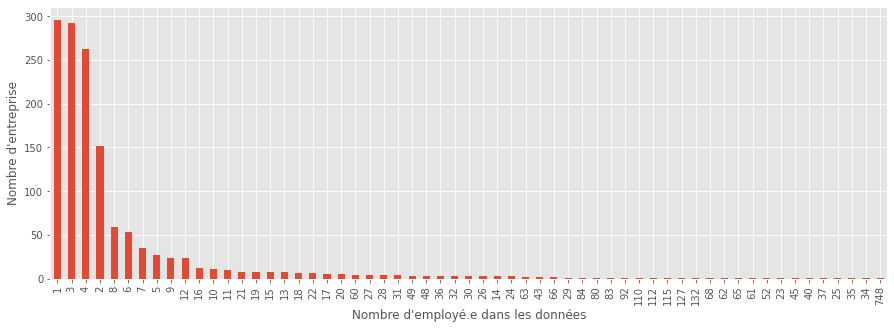

In [40]:
df["Entreprise"].value_counts().value_counts().plot(kind="bar", figsize=(15, 5))
# set xlabel
plt.xlabel("Nombre d'employé.e dans les données")
plt.ylabel("Nombre d'entreprise")

=> Il y a beaucoup d'entreprises qui n'ont que très peut d'employée dans les donées, je ne pense pas qu'on puisse tirer grand chose d'une entreprise avec un ou deux exemples de profile. Je peux peut être garder les entreprises ayant un minimum x d'employé dans le train set

#### Preprocessing

Une nouvelle fonction pour aider au preprocessing (des entreprises)

In [41]:
def keep_elem_with_min_count(df, column, min_count, param, default_value="unknown"):
    """Only keep element in column if they appear at least min_count times. Set other to `unknown`"""
    P_KEY = f"{column}_keeped"
    if P_KEY not in param:
        elem_count = df[column].value_counts()
        param[P_KEY] = elem_count[elem_count > min_count].index.to_list()

    df.loc[~df[column].isin(param[P_KEY]), column] = default_value

Comme pour le clustering, je défini un fonction de preprocessing qui utilise les petites fonctions de preprocessing.

`Technologie`:

même preprocessing que pour le clustering.


`Experience`:

même preprocessing que pour le clustering.

J'utilise l'experience directement et non la version catégorisé `Exp_label` (par ce que les metrics étaient meilleur)


`Diplome` :

même preprocessing que pour le clustering.


`Entreprise` :

même preprocessing que pour le clustering, avec en plus:
- je selectionne les entreprises qui ont au moins 20 employés dans le train set (j'ai testé plusieurs valeur et 20 employés donnait les meilleurs metrics)


`Ville` :

même preprocessing que pour le clustering.

=> Et tout comme pendant le clustering, je n'ai pas utilisé cette feature par ce que les metrics étaient moins bonne avec

In [42]:
def preprocess_for_prediction(df, param=None):
    if param is None:
        param = {}

    df = df.copy()

    # Technologies
    preprocess_technologies(df)
    df = list_to_one_hot_encoding(df, "Technologies", param)
    drop_column(df, "Technologies")

    # Experience
    convert_column_to_float(df, "Experience")
    replace_nan_by_categorical_median(df, "Experience", "Metier", param)

    # Exp_label
    # add_segmented_column(df, "Experience", "Exp_label", [0, 2, 5, 15, 100], ["débutant", "confirmé", "avancé", "expert"], param)
    # ordinal_encoding(df, "Exp_label", ["débutant", "confirmé", "avancé", "expert"], param)
    # drop_column(df, "Exp_label")
    # drop_column(df, "Experience")

    # Diplome
    ordinal_encoding(
        df, "Diplome", ['No diploma', 'Bachelor', 'Master', 'Phd'], param)
    drop_column(df, "Diplome")

    # Entreprise
    lower_column(df, "Entreprise")
    keep_elem_with_min_count(df, "Entreprise", 20, param)
    df = one_hot_encoding(df, "Entreprise", param)
    drop_column(df, "Entreprise")

    # Ville
    # df = one_hot_encoding(df, "Ville", param)
    drop_column(df, "Ville")

    return df, param

1. On sépare le dataset en 2 parties (train et test set)

2. On preprocess le train set, puis le test set (en utilisant les paramètres du train set)

3. On sépare les input et les output

In [43]:
from sklearn.model_selection import train_test_split
SEED = 42

df = pd.read_csv("data.csv")

# Saving observation to predict
to_predict = df[df["Metier"].isna()]
drop_nan(df, "Metier")

# Train test split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=SEED)
print("Train size:", train_df.shape[0])
print("Test size:", test_df.shape[0])

# Preprocessing
train_df, preprocess_param = preprocess_for_prediction(train_df)
test_df, _ = preprocess_for_prediction(test_df, param=preprocess_param)

# Input / output separation
x_train = train_df.drop(["Metier"], axis=1).to_numpy()
y_train = train_df["Metier"].to_numpy()
x_test = test_df.drop(["Metier"], axis=1).to_numpy()
y_test = test_df["Metier"].to_numpy()
print(f"input shape: {x_train.shape}")
print(f"output shape: {y_train.shape}")

Train size: 6694
Test size: 2869
input shape: (6694, 107)
output shape: (6694,)


-> On a 6694 profiles pour entrainer un modèle, avec 107 features

#### Choix du model

Pour choisir un model, j'ai mis en place une cross validation pour finetuner les modeles et choisir les features à utiliser.

Pour comparer chaque entrainement, j'ai utilisé 5 metrics :
- L'accuracy
- La balanced accuracy, plus pertinente étant donné que nos classes ne sont pas équilibrées (il y a moins de Lead Data Scientist)
- La precision
- le recall
- et le F1 score

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "f1": make_scorer(f1_score, average="weighted")
}


def display_cv_metrics(cv_results):
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        metrics_df = pd.DataFrame({
            "mean": [value.mean() * 100 for key, value in cv_results.items() if "test" in key],
            "std": [value.std() * 100 for key, value in cv_results.items() if "test" in key],
        }, index=[k[5:] for k in cv_results.keys() if "test" in k])
        display(metrics_df)
        print(metrics_df)

##### Regression Linéaire

In [45]:
from sklearn.linear_model import SGDClassifier

# Model definiton
sgd = SGDClassifier(loss="log", max_iter=1000, tol=1e-3)

# Cross validation
cv_results = cross_validate(sgd, x_train, y_train, scoring=scoring, cv=5)

display_cv_metrics(cv_results)

,mean,std
accuracy,87.56,0.75
balanced_accuracy,80.06,3.55
precision,87.61,0.41
recall,87.56,0.75
f1,85.43,2.34


                   mean  std
accuracy          87.56 0.75
balanced_accuracy 80.06 3.55
precision         87.61 0.41
recall            87.56 0.75
f1                85.43 2.34


##### Multilayer Perceptron

In [46]:
from sklearn.neural_network import MLPClassifier

# Model definiton
mlp = MLPClassifier(hidden_layer_sizes=(100, 100),
                    activation="relu", max_iter=4000, random_state=SEED)

# Cross validation
cv_results = cross_validate(mlp, x_train, y_train, scoring=scoring, cv=5)

display_cv_metrics(cv_results)

,mean,std
accuracy,87.99,0.49
balanced_accuracy,83.29,1.10
precision,87.35,0.61
recall,87.99,0.49
f1,87.50,0.60


                   mean  std
accuracy          87.99 0.49
balanced_accuracy 83.29 1.10
precision         87.35 0.61
recall            87.99 0.49
f1                87.50 0.60


##### Gradient Boosted Decision Tree

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# Model definiton
gbdt = GradientBoostingClassifier(
    n_estimators=200, max_depth=3, max_features=0.4, random_state=SEED)

# Cross validation
cv_results = cross_validate(gbdt, x_train, y_train, scoring=scoring, cv=5)

display_cv_metrics(cv_results)

,mean,std
accuracy,89.57,0.67
balanced_accuracy,85.06,0.98
precision,89.09,0.71
recall,89.57,0.67
f1,89.10,0.68


                   mean  std
accuracy          89.57 0.67
balanced_accuracy 85.06 0.98
precision         89.09 0.71
recall            89.57 0.67
f1                89.10 0.68


------

Le modèle avec les meilleurs résultat est le Gradient Boosting Decision Tree (`GradientBoostingClassifier`), je le choisie et l'entraine sur le training set

In [48]:
final_model = gbdt
final_model.fit(x_train, y_train)

GradientBoostingClassifier(max_features=0.4, n_estimators=200, random_state=42)

#### Évalutation du model sur le test set

Pour évaluer notre model, en plus des 5 metrics défini précédement, on va utiliser une matrice de confusion (utile pour savoir avec quelle classe le modèle confond le plus).

Je définis une fonction `get_metrics()` qui va nous afficher tout ça

In [49]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, multilabel_confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    labels = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    cm_df = pd.DataFrame(cm, columns=labels, index=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="BuGn",
                square=True, vmin=1, vmax=700, ax=ax)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion matrix')
    plt.yticks(rotation=0)
    plt.show()

    return cm_df


def plot_matrix_confusion_summurized(y_true, y_pred):
    labels = sorted(set(y_true))
    cm_lst = multilabel_confusion_matrix(y_true, y_pred, labels=labels)

    col = ['TN', 'FP', 'FN', 'TP']
    cm_lst_df = pd.DataFrame(cm_lst.reshape(
        len(labels), 4), columns=col, index=labels)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm_lst_df, annot=True, linewidths=.5, cbar=False,
                fmt='d', square=True, cmap="gray", ax=ax)
    fig.tight_layout()
    plt.yticks(rotation=0)
    plt.show()

    return cm_lst_df


def get_metrics(y_true, y_pred, print_metrics=True):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted')

    if print_metrics:
        print(f"Accuracy:\t\t\t{accuracy*100:.2f}")
        print(f"Balanced accuracy:\t{balanced_accuracy*100:.2f}")
        print(f"Precision:\t\t\t{precision*100:.2f}")
        print(f"Recall:\t\t\t\t{recall*100:.2f}")
        print(f"Fscore:\t\t\t\t{fscore*100:.2f}")

        plot_confusion_matrix(y_true, y_pred)
        plot_matrix_confusion_summurized(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "fscore": fscore
    }

Et c'est l'heure de l'évaluation

Accuracy:			90.87
Balanced accuracy:	85.53
Precision:			90.47
Recall:				90.87
Fscore:				90.39


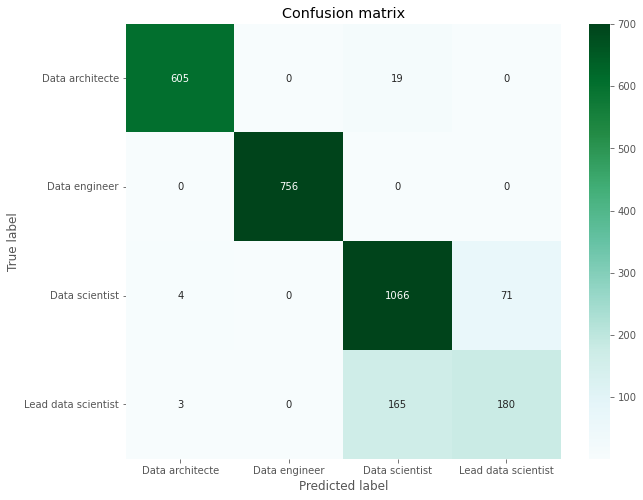

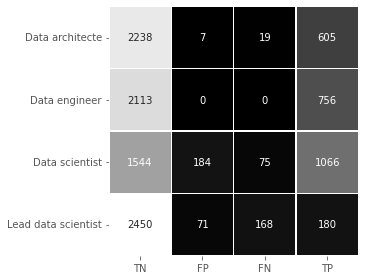

In [50]:
model_pred = final_model.predict(x_test)
metrics = get_metrics(y_test, model_pred)

La balanced accuracy et le f1 score sont similaire au metrics sur le dev set (pendant la cross evaluation) -> la variance est basse, le model n'a pas overfitté !

La matrice de confusion est très intéressante, on voit tout de suite que le model a du mal a différencier les "Data Scientist" et les "Lead Data Scientist". Sur 348 "Lead Data Scientist", il en a classé 47% en "Data Scientist". Néanmoins, la plus part des "Data Scientist" sont eux bien classé.

#### Exploration de la prédiction sur le test set

Regardons qui sont ses 165 "Lead Data Scientist" (LDS) que notre modèle prend pour des "Data Scientist" (DS)

In [51]:
df_analyze = pd.read_csv("data.csv")
df_analyze, _ = preprocess_for_analyze(df_analyze)
drop_nan(df_analyze, "Metier")

In [52]:
lds_df = df_analyze[df_analyze["Metier"] == "Lead data scientist"]
ds_df = df_analyze[df_analyze["Metier"] == "Data scientist"]

# Good "Lead data scientist" prediciton
good_lds_df = df_analyze[df_analyze.index.isin(test_df[(
    (y_test == "Lead data scientist") & (model_pred == "Lead data scientist"))].index)]

# "Lead data scientist" predicted as "data scientist"
error_df = df_analyze[df_analyze.index.isin(test_df[(
    (y_test == "Lead data scientist") & (model_pred == "Data scientist"))].index)]
error_df["Metier"].value_counts()

Lead data scientist    165
Name: Metier, dtype: int64

In [53]:
df_lst = [
    ("Good LDS prediction", good_lds_df),
    ("LDS wrongly predicted as DS", error_df),
    ("Lead data scientist", lds_df),
    ("Data scientist", ds_df),
]

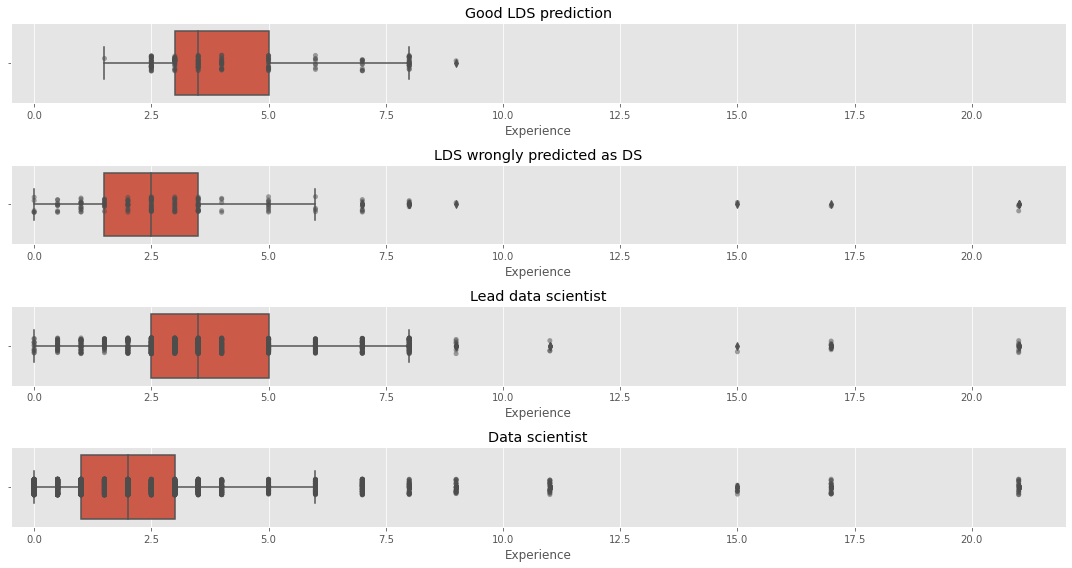

In [54]:
# Comparing Experience

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
for i, (title, df) in enumerate(df_lst):
    sns.boxplot(x="Experience", data=df, ax=ax[i])
    sns.stripplot(x="Experience", data=df, color=".3", alpha=0.5, ax=ax[i])
    ax[i].set_xlim(-.5, 22)
    ax[i].title.set_text(title)

fig.tight_layout()
plt.show()

La plus part des LDS prédit comme des DS ont effectivment moins d'expérience que les LDS classique, comme les DS classique

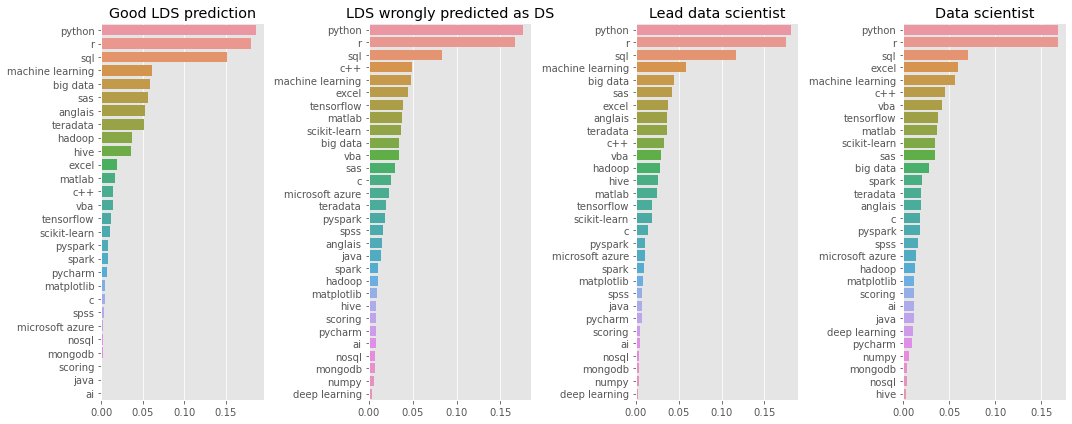

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
for i, (title, df) in enumerate(df_lst):
    tech_count = to_1D(df["Technologies"]).value_counts(normalize=True)
    sns.barplot(x=tech_count.values, y=tech_count.index, ax=ax[i])
    ax[i].title.set_text(title)

fig.tight_layout()
plt.show()

Python, R, SQL et Machine Learning sont utilisé par nos 4 groupes (dans tous les top 5).

`big data` est la 5ème techno la plus utilisé par les LDS et les LDS bien prédit. Elle est seulement 10 ème chez les LDS mal prédit (et 12ème chez les DS). On peut voir la même logique pour les technologies `taradata`, `Hadoop` ou `Hive`.

On peut aussi remarquer le C++ très haut chez les LDS mal prédit (et les DS) et plus bas chez les LDS et LDS bien prédit

Un TF-IDF pourrait être intéréssent pour faire ressortir les technologies caractéristiques de chaque groupe

In [56]:
good_lds_df["Entreprise"].value_counts(normalize=True).multiply(100)

ball aerospace                                     23.333333
emory university                                    3.333333
wayfair                                             2.222222
georgia tech research institute                     2.222222
the home depot                                      1.666667
                                                     ...    
effective spend                                     0.555556
global pharmaceutical company via rch solutions     0.555556
bank of america                                     0.555556
epiq systems, inc.                                  0.555556
children's healthcare of atlanta                    0.555556
Name: Entreprise, Length: 103, dtype: float64

In [57]:
error_df["Entreprise"].value_counts(normalize=True).multiply(100)

ball aerospace                   6.060606
university of texas at austin    4.848485
kpmg                             3.030303
amazon.com                       2.424242
indigo                           2.424242
                                   ...   
j.e. ranta associates            0.606061
workbridge associates            0.606061
general motors                   0.606061
sovrn holdings                   0.606061
pluralsight                      0.606061
Name: Entreprise, Length: 121, dtype: float64

Les LDS mal prédit ne semble pas venir d'une entreprise en particulier

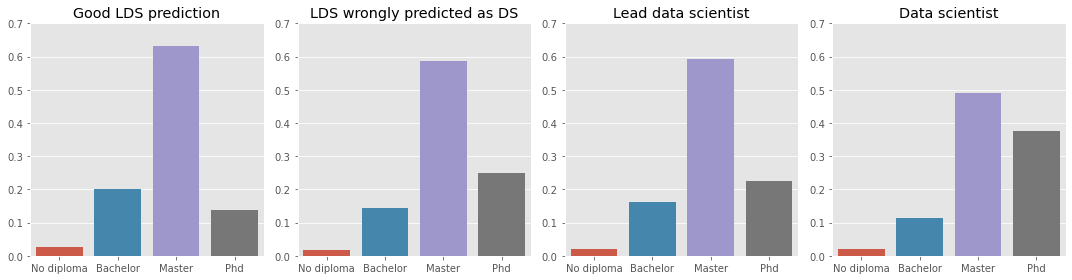

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for i, (title, df) in enumerate(df_lst):
    dip_count = df["Diplome"].value_counts(normalize=True)
    sns.barplot(y=dip_count.values, x=dip_count.index, ax=ax[i], order=[
                "No diploma", "Bachelor", "Master", "Phd"])
    ax[i].set_ylim(0, 0.7)
    ax[i].title.set_text(title)

fig.tight_layout()
plt.show()

Il y a un peu plus de Phd chez les LDS mal prédit, mais c'est peu

#### Prédiction finale

In [59]:
# preprocessing
pred_prepro, _ = preprocess_for_prediction(to_predict, preprocess_param)
pred_input = pred_prepro.drop(["Metier"], axis=1).to_numpy()

# prediction
pred_result = final_model.predict(pred_input)
to_predict["Metier"] = pred_result
to_predict

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
346,Jacobs,Data engineer,Python/Spark/GNU/Linux,No diploma,"2,5",Paris
2058,Ball Aerospace,Lead data scientist,VBA/Python/Excel/R,Master,15,Lyon
2670,"eHire, LLC",Data scientist,Java/C/C++/R/Python,Master,"1,5",Toulouse
2899,Norfolk Southern Corp,Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0,Grenoble
3346,J.E. Ranta Associates,Data architecte,Cassandra/MongoDB/NoSQL/AWS,Master,7,Rennes
4248,KPMG,Data scientist,Python/Microsoft Azure/R/SQL,Phd,2,Lyon
4290,"Pandora Media, Inc.",Data scientist,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,"1,5",Toulouse
4292,Partners HealthCare(PHS),Lead data scientist,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8,Bordeaux
5425,Ashton Lane Group,Data engineer,Python/Pyspark/Spark,No diploma,5,Lyon
5593,Lighthouse Lab Services,Data scientist,Python/R/machine learning/Excel/VBA/C++,Master,3,Lyon


In [60]:
to_predict.to_csv("prediction.csv", index=True)